In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

path = "/content/cleaned_nyc_squirrels.csv"
df = pd.read_csv(path)
df

long        lat unique_squirrel_id hectare shift        date  \
0    -73.956134  40.794082     37F-PM-1014-03     37F    PM  2018-10-14   
1    -73.957044  40.794851     37E-PM-1006-03     37E    PM  2018-10-06   
2    -73.976831  40.766718      2E-AM-1010-03     02E    AM  2018-10-10   
3    -73.975725  40.769703      5D-PM-1018-05     05D    PM  2018-10-18   
4    -73.959313  40.797533     39B-AM-1018-01     39B    AM  2018-10-18   
...         ...        ...                ...     ...   ...         ...   
3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM  2018-10-07   
3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM  2018-10-13   
3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM  2018-10-12   
3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM  2018-10-10   
3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM  2018-10-12   

      hectare_squirrel_number       age primary_fur_color  \
0                           3       NaN           Unknown   
1                           3     Adult              Gray   
2                           3     Adult          Cinnamon   
3                           5  Juvenile              Gray   
4                           1       NaN           Unknown   
...                       ...       ...               ...   
3018                        4     Adult              Gray   
3019                        5     Adult              Gray   
3020                        7     Adult              Gray   
3021                        2       NaN              Gray   
3022                        1     Adult          Cinnamon   

         highlight_fur_color  ... tail_flags tail_twitches approaches  \
0                    Unknown  ...      False         False      False   
1                   Cinnamon  ...      False         False      False   
2                    Unknown  ...      False         False      False   
3                    Unknown  ...      False         False      False   
4                    Unknown  ...      False         False      False   
...                      ...  ...        ...           ...        ...   
3018                 Unknown  ...      False         False      False   
3019                   White  ...      False         False      False   
3020  Black, cinnamon, white  ...      False         False      False   
3021         Cinnamon, white  ...      False         False      False   
3022             Gray, white  ...      False         False       True   

      indifferent  runs_from                                      lat_long  \
0           False      False    POINT (-73.9561344937861 40.7940823884086)   
1           False       True  POINT (-73.9570437717691 40.794850940803904)   
2            True      False   POINT (-73.9768311751004 40.76671780725581)   
3           False       True    POINT (-73.9757249834141 40.7697032606755)   
4           False      False     POINT (-73.9593126695714 40.797533370163)   
...           ...        ...                                           ...   
3018        False       True    POINT (-73.9639431360458 40.7908677445466)   
3019         True      False    POINT (-73.9704015859639 40.7825600069973)   
3020         True      False    POINT (-73.9665871993517 40.7836775064883)   
3021         True      False    POINT (-73.9639941227864 40.7899152327912)   
3022        False      False    POINT (-73.9754794191553 40.7696404489025)   

      community_districts  borough_boundaries  city_council_districts  \
0                      19                   4                      19   
1                      19                   4                      19   
2                      19                   4                      19   
3                      19                   4                      19   
4                      19                   4                      19   
...                   ...                 ...                     ...   
3018                   19                   4       

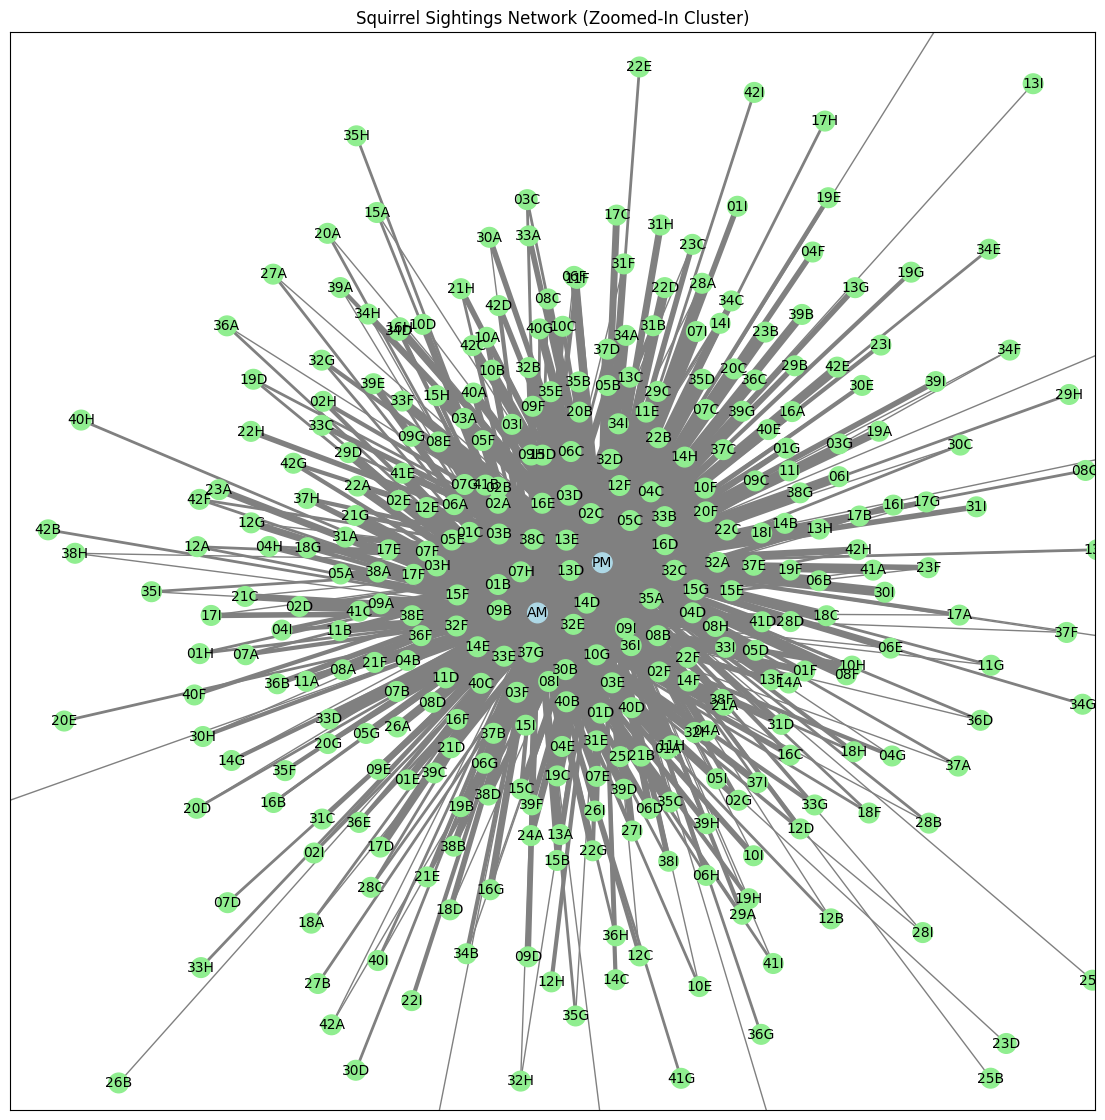

<Figure size 640x480 with 0 Axes>

In [ ]:
# Initialize the graph
G = nx.Graph()

# Dictionary to store edge attributes (only for weight now)
edge_attrs = {}

# Add node attributes for Hectare (Location) based on squirrel age
for location, group in df.groupby('hectare'):
    juvenile_count = group[group['age'] == 'Juvenile'].shape[0]
    adult_count = group[group['age'] == 'Adult'].shape[0]

    # Add node for each Hectare with attributes for juvenile and adult counts
    G.add_node(location, juvenile=juvenile_count, adult=adult_count)

# Add node attributes for Shift (AM/PM) based on squirrel age
for shift, group in df.groupby('shift'):
    juvenile_count = group[group['age'] == 'Juvenile'].shape[0]
    adult_count = group[group['age'] == 'Adult'].shape[0]

    # Add node for each Shift with attributes for juvenile and adult counts
    G.add_node(shift, juvenile=juvenile_count, adult=adult_count)

# Group by Hectare and Shift to find the frequency of sightings
sightings = df.groupby(['hectare', 'shift', 'age']).size().reset_index(name='Sightings')

# Loop over the sightings and prepare edge attributes
for index, row in sightings.iterrows():
    location = row['hectare']  # Use Hectare as a node
    shift = row['shift']       # Use Shift (AM/PM) as another node
    weight = row['Sightings']  # Number of sightings for this age group

    # Create a unique key for the edge between location and shift
    edge_key = (location, shift)

    # If the edge already exists, increment the weight
    if edge_key in edge_attrs:
        edge_attrs[edge_key]['weight'] += weight
    else:
        # Store the edge with its weight
        edge_attrs[edge_key] = {'weight': weight}

# Add edges and their attributes to the graph
for edge, attr in edge_attrs.items():
    G.add_edge(edge[0], edge[1], **attr)

# Color nodes based on their type: Hectare (Location) or Shift (AM/PM)
node_colors = []
for node in G.nodes():
    if node in df['hectare'].values:
        node_colors.append('lightgreen')  # Color for locations (Hectares)
    else:
        node_colors.append('lightblue')   # Color for shifts (AM/PM)

# Adjust layout, figure size, and other parameters
plt.figure(figsize=(14, 14))  # Increase figure size for better zoom

# Use spring_layout for clustering
pos = nx.spring_layout(G)  # Spring layout for better node spacing

# Draw nodes with smaller sizes (e.g., 100 or 200 instead of default 500)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors)

# Draw edges with widths based on the number of sightings (weight)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], edge_color='gray')

# Add node labels (e.g., label hectares and shifts)
nx.draw_networkx_labels(G, pos, font_size=10)

# Adjust the axis limits to zoom into the cluster (you may need to fine-tune these based on your data)
plt.xlim(-0.1, 0.1)  # Adjust x-axis limits to zoom into the cluster
plt.ylim(-0.1, 0.1)  # Adjust y-axis limits to zoom into the cluster

# Show the plot
plt.title("Squirrel Sightings Network (Zoomed-In Cluster)")
plt.show()

# Optionally save the plot
plt.savefig('squirrel_network_zoomed_cluster.png')


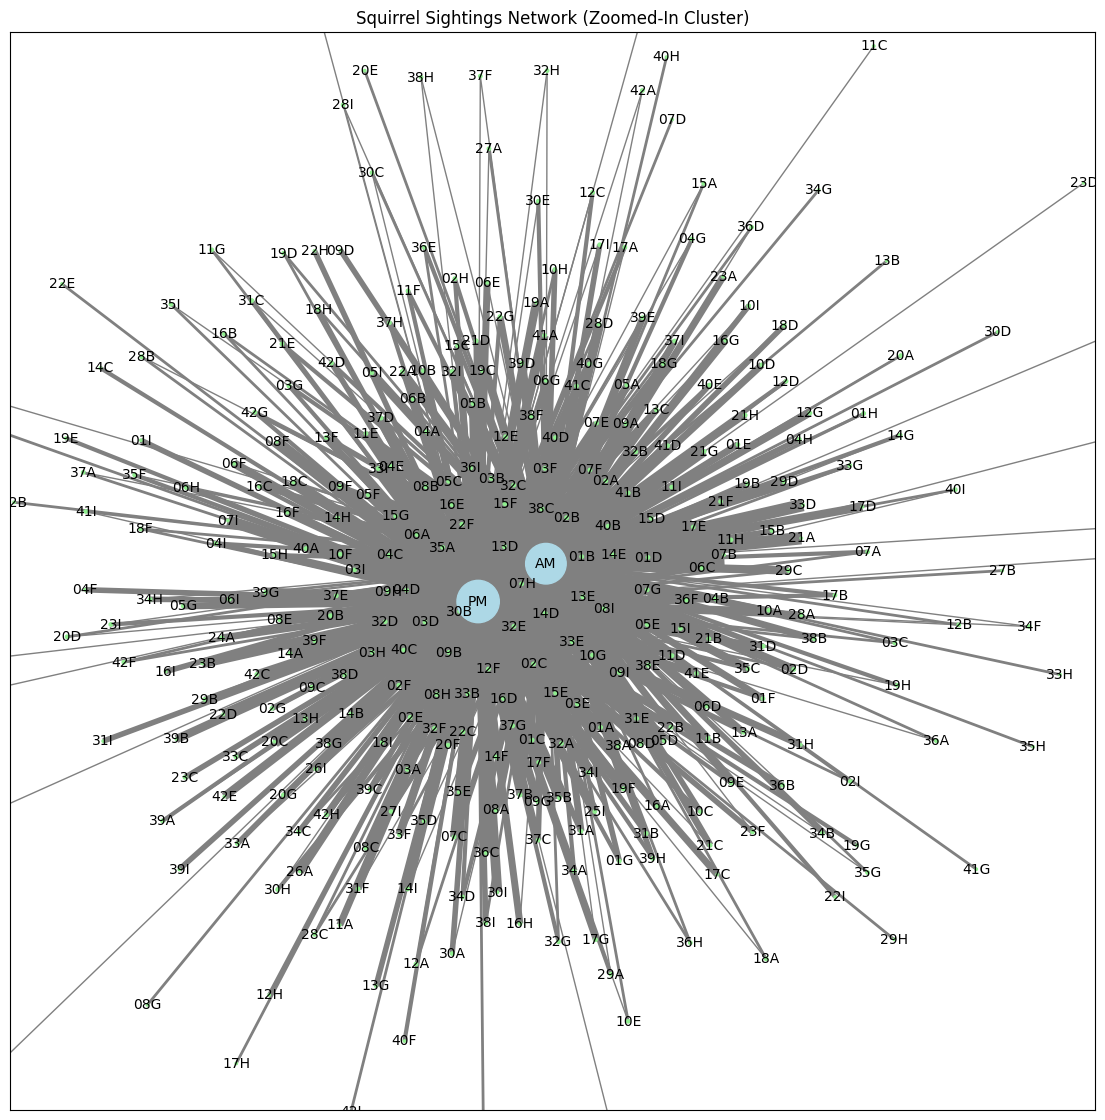

<Figure size 640x480 with 0 Axes>

In [ ]:

# Initialize the graph
G = nx.Graph()

# Dictionary to store edge attributes (only for weight now)
edge_attrs = {}

# Add node attributes for Hectare (Location) based on squirrel age
for location, group in df.groupby('hectare'):
    juvenile_count = group[group['age'] == 'Juvenile'].shape[0]
    adult_count = group[group['age'] == 'Adult'].shape[0]

    # Add node for each Hectare with attributes for juvenile and adult counts
    G.add_node(location, juvenile=juvenile_count, adult=adult_count)

# Add node attributes for Shift (AM/PM) based on squirrel age
for shift, group in df.groupby('shift'):
    juvenile_count = group[group['age'] == 'Juvenile'].shape[0]
    adult_count = group[group['age'] == 'Adult'].shape[0]

    # Add node for each Shift with attributes for juvenile and adult counts
    G.add_node(shift, juvenile=juvenile_count, adult=adult_count)

# Group by Hectare and Shift to find the frequency of sightings
sightings = df.groupby(['hectare', 'shift', 'age']).size().reset_index(name='Sightings')

# Loop over the sightings and prepare edge attributes
for index, row in sightings.iterrows():
    location = row['hectare']  # Use Hectare as a node
    shift = row['shift']       # Use Shift (AM/PM) as another node
    weight = row['Sightings']  # Number of sightings for this age group

    # Create a unique key for the edge between location and shift
    edge_key = (location, shift)

    # If the edge already exists, increment the weight
    if edge_key in edge_attrs:
        edge_attrs[edge_key]['weight'] += weight
    else:
        # Store the edge with its weight
        edge_attrs[edge_key] = {'weight': weight}

# Add edges and their attributes to the graph
for edge, attr in edge_attrs.items():
    G.add_edge(edge[0], edge[1], **attr)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Color nodes based on their type: Hectare (Location) or Shift (AM/PM)
node_colors = []
for node in G.nodes():
    if node in df['hectare'].values:
        node_colors.append('lightgreen')  # Color for locations (Hectares)
    else:
        node_colors.append('lightblue')   # Color for shifts (AM/PM)

# Adjust layout, figure size, and other parameters
plt.figure(figsize=(14, 14))  # Increase figure size for better zoom

# Use spring_layout for clustering
pos = nx.spring_layout(G)  # Spring layout for better node spacing

# Draw nodes with smaller sizes (e.g., 100 or 200 instead of default 500)
# You could adjust node size based on centrality for visualization
node_size = [1000 * degree_centrality[n] for n in G.nodes()]  # Node size proportional to degree centrality
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors)

# Draw edges with widths based on the number of sightings (weight)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], edge_color='gray')

# Add node labels (e.g., label hectares and shifts)
nx.draw_networkx_labels(G, pos, font_size=10)

# Adjust the axis limits to zoom into the cluster (you may need to fine-tune these based on your data)
plt.xlim(-0.1, 0.1)  # Adjust x-axis limits to zoom into the cluster
plt.ylim(-0.1, 0.1)  # Adjust y-axis limits to zoom into the cluster

# Show the plot
plt.title("Squirrel Sightings Network (Zoomed-In Cluster)")
plt.show()

# Optionally save the plot
plt.savefig('squirrel_network_zoomed_cluster.png')


In [ ]:
import numpy as np

# Extract centrality values
centrality_values = np.array([centrality for node, centrality in degree_centrality.items()])

# L1 normalization
l1_normalized = centrality_values / np.sum(np.abs(centrality_values))

# L2 normalization
l2_normalized = centrality_values / np.sqrt(np.sum(centrality_values ** 2))

# Display the normalized values
print("L1 Normalized Centrality:")
for node, normalized_value in zip(degree_centrality.keys(), l1_normalized):
    print(f"Node: {node}, Degree Centrality (L1): {normalized_value}")



L1 Normalized Centrality:
Node: 01A, Degree Centrality (L1): 0.0016501650165016502
Node: 01B, Degree Centrality (L1): 0.0016501650165016502
Node: 01C, Degree Centrality (L1): 0.0016501650165016502
Node: 01D, Degree Centrality (L1): 0.0016501650165016502
Node: 01E, Degree Centrality (L1): 0.0016501650165016502
Node: 01F, Degree Centrality (L1): 0.0016501650165016502
Node: 01G, Degree Centrality (L1): 0.0016501650165016502
Node: 01H, Degree Centrality (L1): 0.0016501650165016502
Node: 01I, Degree Centrality (L1): 0.0008250825082508251
Node: 02A, Degree Centrality (L1): 0.0016501650165016502
Node: 02B, Degree Centrality (L1): 0.0016501650165016502
Node: 02C, Degree Centrality (L1): 0.0016501650165016502
Node: 02D, Degree Centrality (L1): 0.0016501650165016502
Node: 02E, Degree Centrality (L1): 0.0016501650165016502
Node: 02F, Degree Centrality (L1): 0.0016501650165016502
Node: 02G, Degree Centrality (L1): 0.0016501650165016502
Node: 02H, Degree Centrality (L1): 0.0016501650165016502
Node:

In [ ]:
betweenness_centrality

{'01A': 6.34314689494283e-05,
 '01B': 6.34314689494283e-05,
 '01C': 6.34314689494283e-05,
 '01D': 6.34314689494283e-05,
 '01E': 6.34314689494283e-05,
 '01F': 6.34314689494283e-05,
 '01G': 6.34314689494283e-05,
 '01H': 6.34314689494283e-05,
 '01I': 0.0,
 '02A': 6.34314689494283e-05,
 '02B': 6.34314689494283e-05,
 '02C': 6.34314689494283e-05,
 '02D': 6.34314689494283e-05,
 '02E': 6.34314689494283e-05,
 '02F': 6.34314689494283e-05,
 '02G': 6.34314689494283e-05,
 '02H': 6.34314689494283e-05,
 '02I': 6.34314689494283e-05,
 '03A': 6.34314689494283e-05,
 '03B': 6.34314689494283e-05,
 '03C': 6.34314689494283e-05,
 '03D': 6.34314689494283e-05,
 '03E': 6.34314689494283e-05,
 '03F': 6.34314689494283e-05,
 '03G': 6.34314689494283e-05,
 '03H': 6.34314689494283e-05,
 '03I': 6.34314689494283e-05,
 '04A': 6.34314689494283e-05,
 '04B': 6.34314689494283e-05,
 '04C': 6.34314689494283e-05,
 '04D': 6.34314689494283e-05,
 '04E': 6.34314689494283e-05,
 '04F': 0.0,
 '04G': 6.34314689494283e-05,
 '04H': 6.3431

In [ ]:


# Sort the degree centrality dictionary from high to low
sorted_betweeness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

# Display the sorted degree centrality values (from high to low)
for node, centrality in sorted_degree_centrality:
    print(f"Node: {node}, Degree Centrality: {betweenness_centrality}")

Node: PM, Degree Centrality: {'01A': 6.34314689494283e-05, '01B': 6.34314689494283e-05, '01C': 6.34314689494283e-05, '01D': 6.34314689494283e-05, '01E': 6.34314689494283e-05, '01F': 6.34314689494283e-05, '01G': 6.34314689494283e-05, '01H': 6.34314689494283e-05, '01I': 0.0, '02A': 6.34314689494283e-05, '02B': 6.34314689494283e-05, '02C': 6.34314689494283e-05, '02D': 6.34314689494283e-05, '02E': 6.34314689494283e-05, '02F': 6.34314689494283e-05, '02G': 6.34314689494283e-05, '02H': 6.34314689494283e-05, '02I': 6.34314689494283e-05, '03A': 6.34314689494283e-05, '03B': 6.34314689494283e-05, '03C': 6.34314689494283e-05, '03D': 6.34314689494283e-05, '03E': 6.34314689494283e-05, '03F': 6.34314689494283e-05, '03G': 6.34314689494283e-05, '03H': 6.34314689494283e-05, '03I': 6.34314689494283e-05, '04A': 6.34314689494283e-05, '04B': 6.34314689494283e-05, '04C': 6.34314689494283e-05, '04D': 6.34314689494283e-05, '04E': 6.34314689494283e-05, '04F': 0.0, '04G': 6.34314689494283e-05, '04H': 6.343146894